In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings
import seaborn as sns
import re

In [2]:
train_df = pd.read_csv('./dataset/train.csv')
train_label = pd.read_csv('./dataset/train_label_coordinates.csv')
train_description = pd.read_csv('./dataset/train_series_descriptions.csv')
print("Total Cases: ", len(train_df))
train_df.head()

Total Cases:  1975


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [11]:
train_df.columns

Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

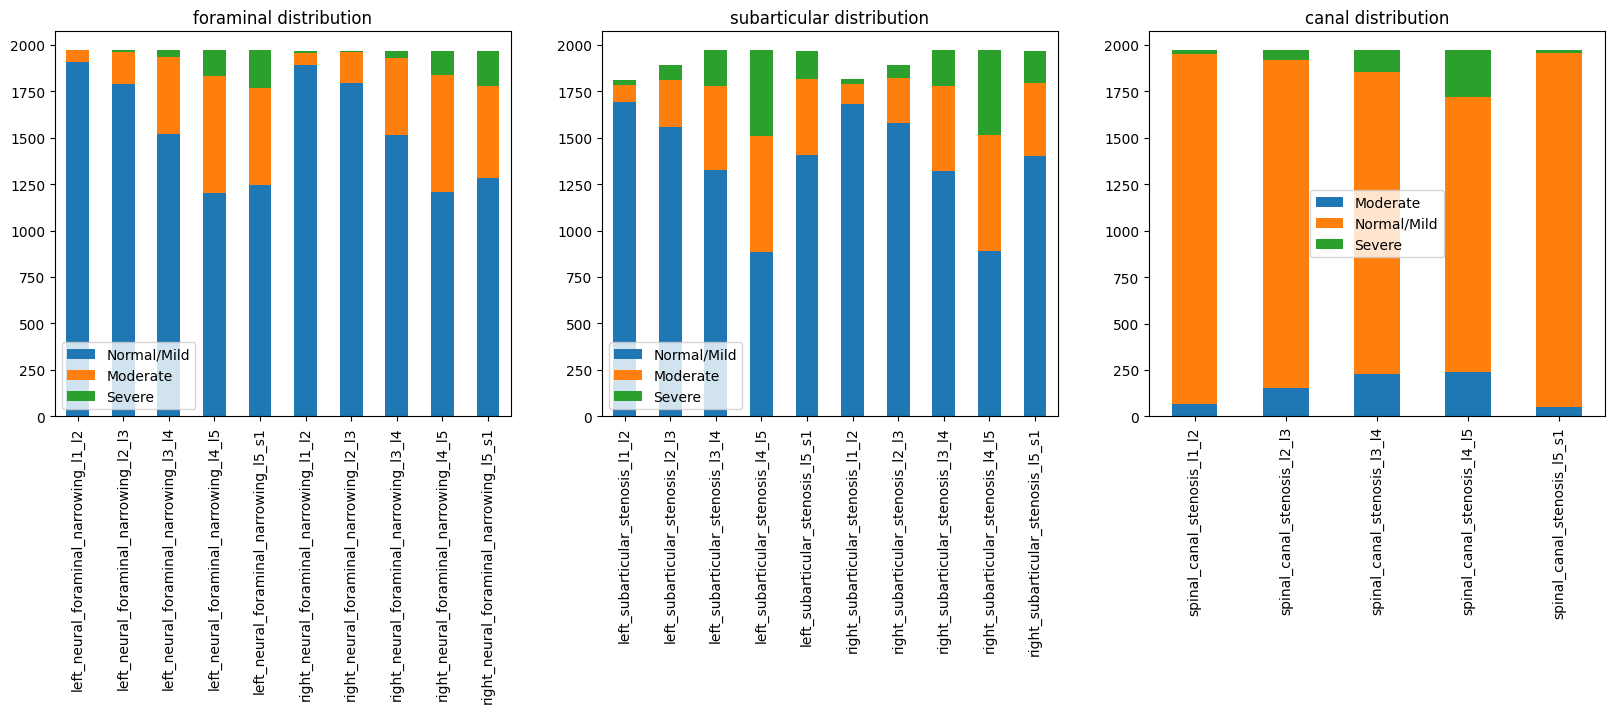

In [12]:
figure, axis = plt.subplots(1,3, figsize=(20,5))
for idx, d in enumerate(['foraminal', 'subarticular', 'canal']):
    diagnosis = list(filter(lambda x: x.find(d) > -1, train_df.columns))
    dff = train_df[diagnosis]
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        value_counts = dff.apply(pd.value_counts).fillna(0).T
    value_counts.plot(kind='bar', stacked=True, ax=axis[idx])
    axis[idx].set_title(f'{d} distribution')

****缺失值查看****

In [13]:
# 检查数据集中的缺失值情况
missing_values = train_df.isnull().sum()

# 显示缺失值信息
missing_values[missing_values > 0]

spinal_canal_stenosis_l1_l2                 1
spinal_canal_stenosis_l2_l3                 1
spinal_canal_stenosis_l3_l4                 1
spinal_canal_stenosis_l4_l5                 1
spinal_canal_stenosis_l5_s1                 1
left_neural_foraminal_narrowing_l1_l2       2
left_neural_foraminal_narrowing_l2_l3       2
left_neural_foraminal_narrowing_l3_l4       2
left_neural_foraminal_narrowing_l4_l5       2
left_neural_foraminal_narrowing_l5_s1       2
right_neural_foraminal_narrowing_l1_l2      8
right_neural_foraminal_narrowing_l2_l3      8
right_neural_foraminal_narrowing_l3_l4      8
right_neural_foraminal_narrowing_l4_l5      8
right_neural_foraminal_narrowing_l5_s1      8
left_subarticular_stenosis_l1_l2          164
left_subarticular_stenosis_l2_l3           82
left_subarticular_stenosis_l3_l4            3
left_subarticular_stenosis_l4_l5            3
left_subarticular_stenosis_l5_s1           11
right_subarticular_stenosis_l1_l2         161
right_subarticular_stenosis_l2_l3 

In [14]:
# 检查并打印缺失值的具体位置
missing_values1 = train_df.isnull()
for col in missing_values1.columns:
    if missing_values1[col].any():
        print(f"Missing values in column {col}:")
        # 打印出具体缺失值的行索引
        print(missing_values1[missing_values1[col]].index.tolist())

Missing values in column spinal_canal_stenosis_l1_l2:
[1378]
Missing values in column spinal_canal_stenosis_l2_l3:
[1378]
Missing values in column spinal_canal_stenosis_l3_l4:
[1378]
Missing values in column spinal_canal_stenosis_l4_l5:
[1378]
Missing values in column spinal_canal_stenosis_l5_s1:
[1378]
Missing values in column left_neural_foraminal_narrowing_l1_l2:
[1126, 1272]
Missing values in column left_neural_foraminal_narrowing_l2_l3:
[1126, 1272]
Missing values in column left_neural_foraminal_narrowing_l3_l4:
[1126, 1272]
Missing values in column left_neural_foraminal_narrowing_l4_l5:
[1126, 1272]
Missing values in column left_neural_foraminal_narrowing_l5_s1:
[1126, 1272]
Missing values in column right_neural_foraminal_narrowing_l1_l2:
[217, 226, 348, 1126, 1135, 1188, 1272, 1740]
Missing values in column right_neural_foraminal_narrowing_l2_l3:
[217, 226, 348, 1126, 1135, 1188, 1272, 1740]
Missing values in column right_neural_foraminal_narrowing_l3_l4:
[217, 226, 348, 1126, 1

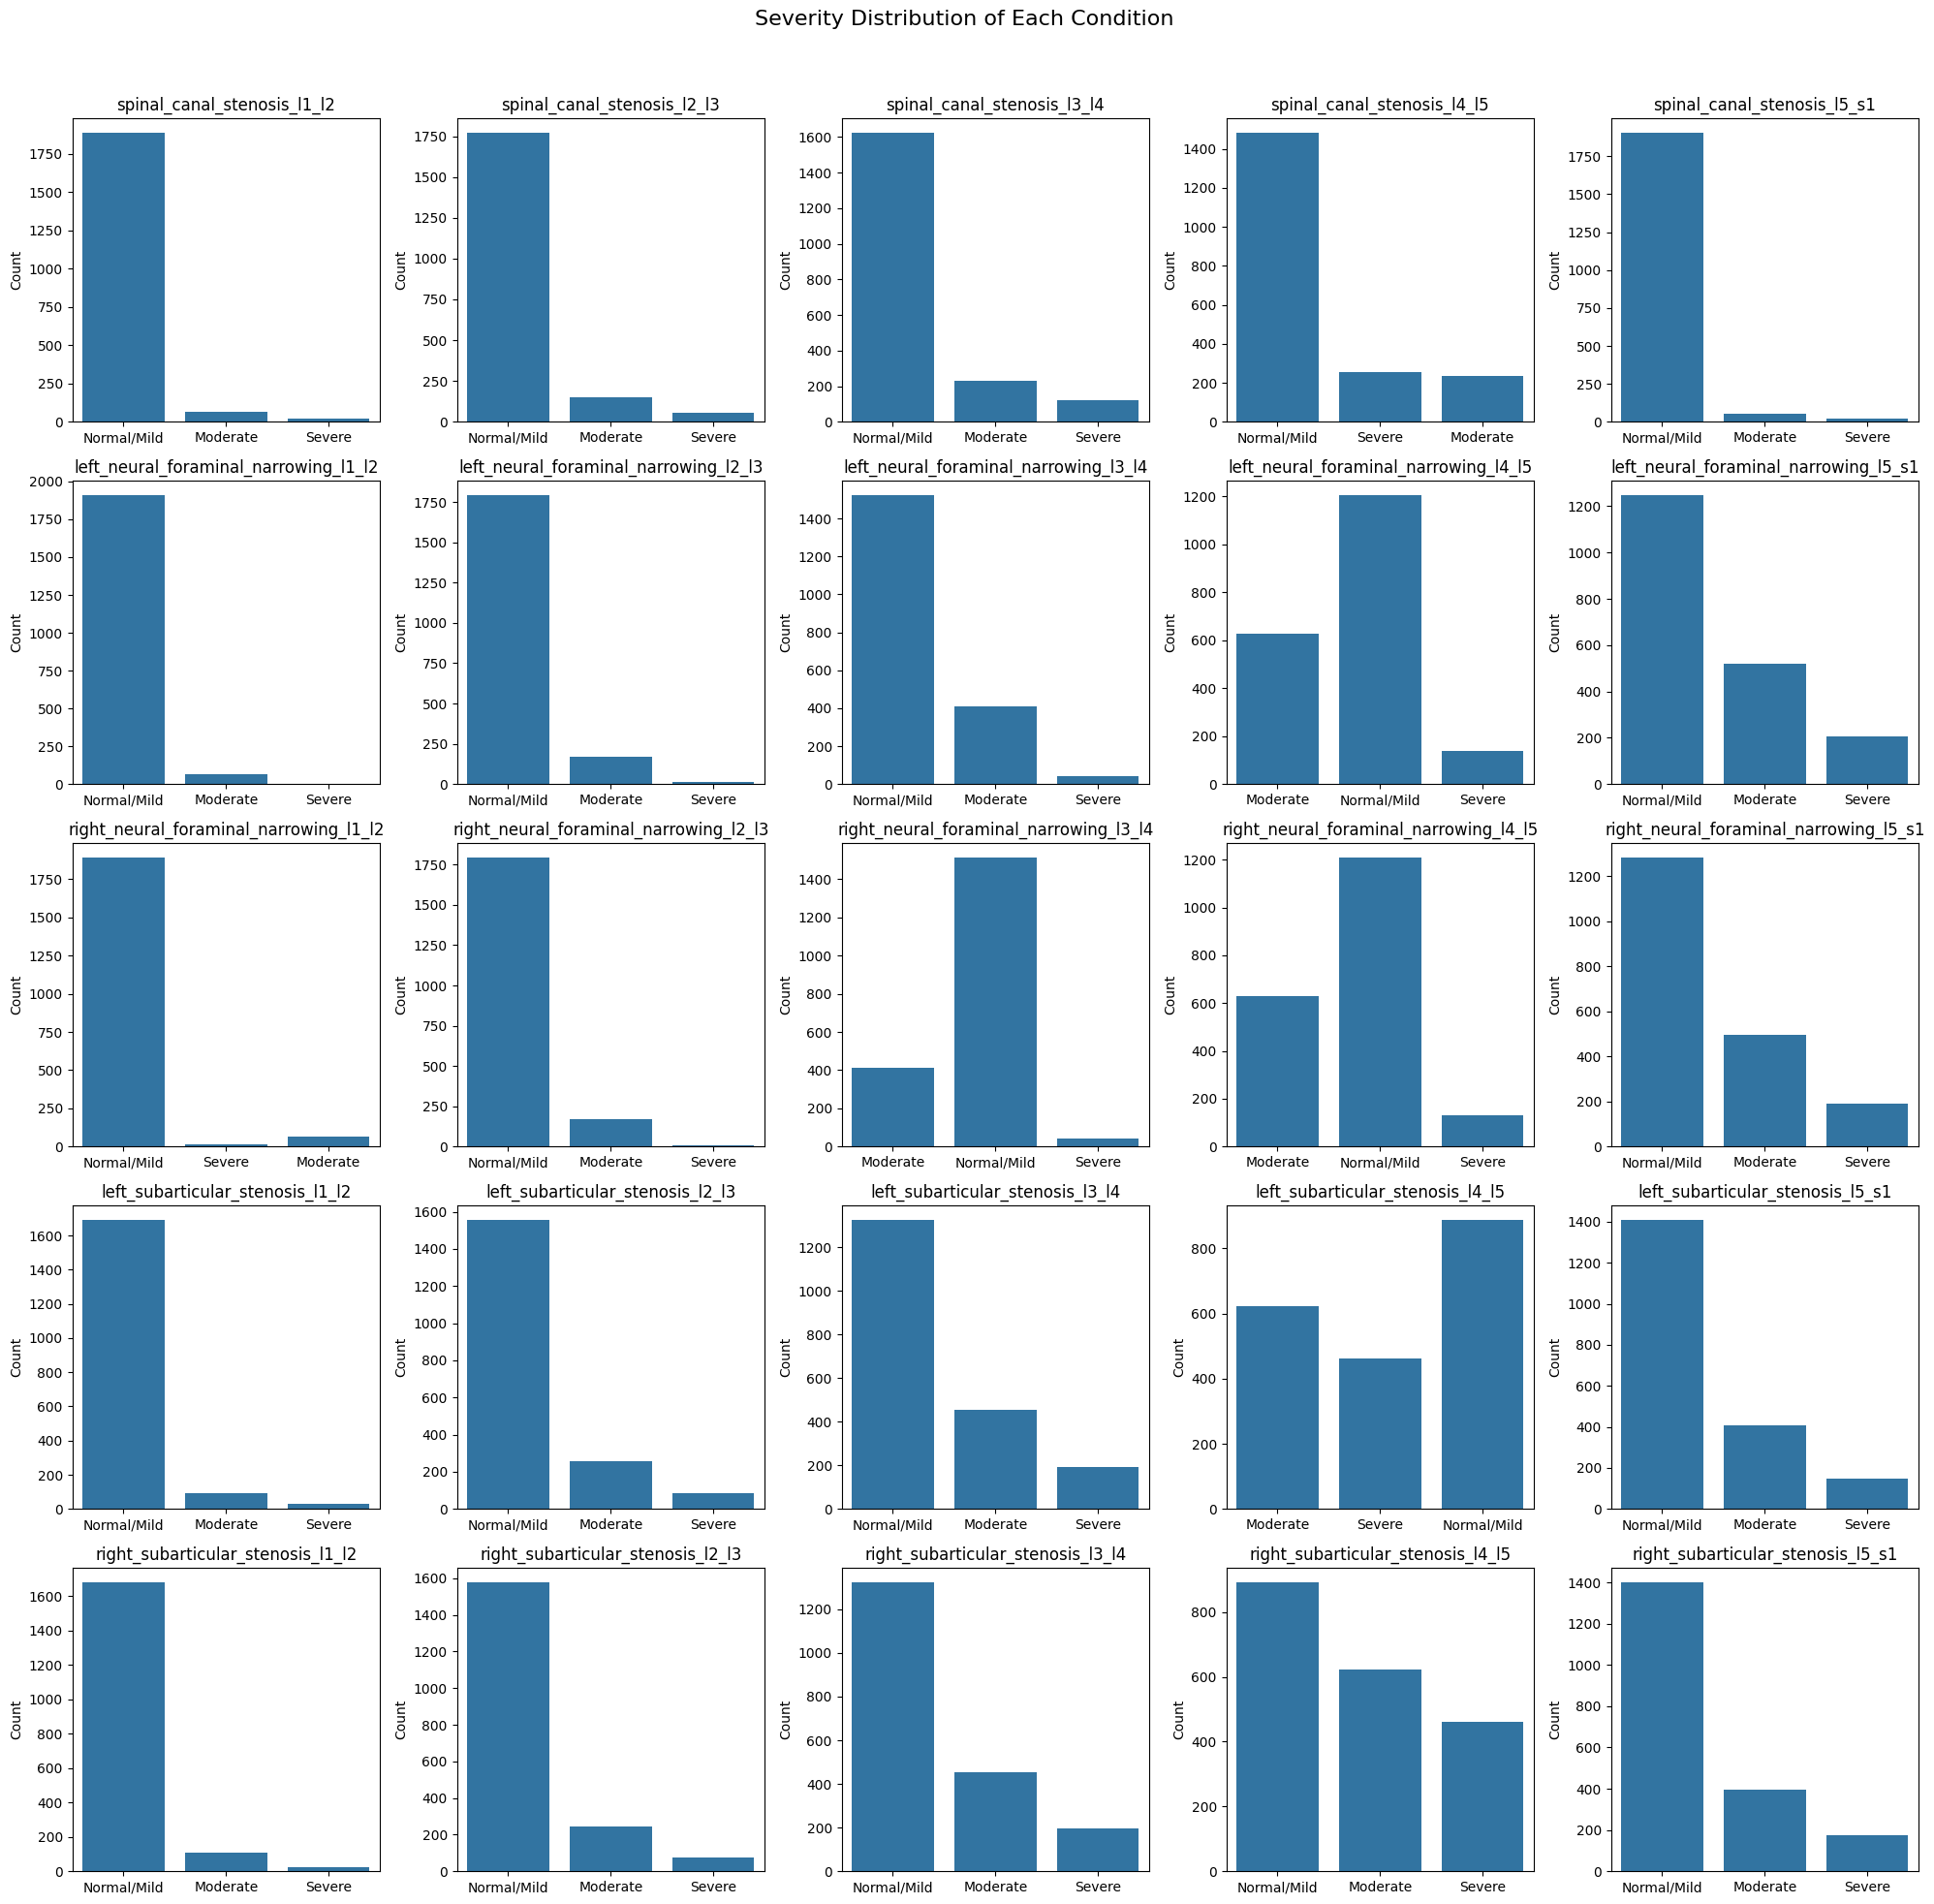

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制标签分布图
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
fig.suptitle('Severity Distribution of Each Condition', fontsize=16)

conditions = train_df.columns[1:]
for i, condition in enumerate(conditions):
    ax = axes[i // 5, i % 5]
    sns.countplot(data=train_df, x=condition, ax=ax)
    ax.set_title(condition)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [5]:
# train.csv和train_label_coordinates.csv 合并
df_train_step_1 = pd.merge(left=train_label, right=train_df, how='left', on='study_id').reset_index(drop=True)
df_train_step_1.head()

,study_id,series_id,instance_number,condition,level,x,y,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [6]:
# df_train_step_1和train_series_descriptions.csv 合并
df_train = pd.merge(left=df_train_step_1, right=train_description, how='left', on=['study_id', 'series_id']).reset_index(drop=True)
df_train.head()

,study_id,series_id,instance_number,condition,level,x,y,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,...,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR


Axial T2            2340
Sagittal T1         1980
Sagittal T2/STIR    1974
Name: series_description, dtype: int64


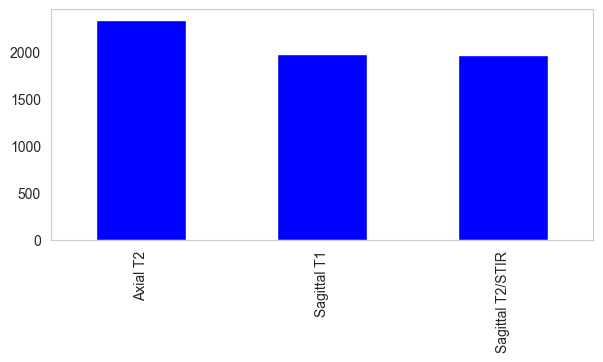

In [3]:
counts = train_description.series_description.value_counts()
print(counts)
plt.figure(figsize=(7,3))
counts.plot(kind='bar', color='blue')
plt.grid()
plt.show()